# Cancer diagnosis in histopathological image: CNN based approach 论文复现

## 1. 导入必要的库

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from typing import Union, Tuple, Dict, List, Optional, cast, Any
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
import random
from tqdm import tqdm

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# matplotlib 中文字体/样式 设置
plt.rcParams['font.family'] = 'SimHei'
plt.style.use('ggplot')

## 2. 数据加载和探索

In [2]:
def load_breakhis_dataset(
    data_dir: Union[str, Path], img_size: Tuple[int, int]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    读取 BreakHis 数据集，并将图像数据和对应标签分开。

    参数:
        data_dir (Union[str, Path]): 包含 A-H 文件夹的根目录路径
        img_size (Tuple[int, int]): 图像大小 (width, height)

    返回:
        X (np.ndarray): 图像数据数组，形状 (N, H, W, C)
        y (np.ndarray): 标签数组
    """
    data_path = Path(data_dir)
    if not data_path.exists():
        raise FileNotFoundError(f"数据目录 {data_path} 不存在")

    subtypes = sorted([d.name for d in data_path.iterdir() if d.is_dir()])

    X = []
    y = []

    for subtype in subtypes:
        folder = data_path / subtype
        for img_path in folder.glob("*.png"):
            img = Image.open(img_path)
            if img_size is not None:
                img = img.resize(img_size, Image.Resampling.LANCZOS)
            arr = np.array(img)
            X.append(arr)
            if subtype in ['A', 'B', 'C', 'D']:
                label = 'B'
            else:
                label = 'M'
            y.append(label)

    X = np.stack(X, axis=0)
    y = np.array(y)

    return X, y


# 加载数据
DATA_DIR = Path("datasets")
X, y = load_breakhis_dataset(DATA_DIR, img_size=(350, 230))
print(f"数据读取完成，样本数: {X.shape[0]}, 图像尺寸: {X.shape[1:]}")

数据读取完成，样本数: 1995, 图像尺寸: (230, 350, 3)


## 模型训练
下表为论文的 特征提取部分结构设计表（即卷积层）

| Layer attribute  | L1   | L2    | L3   | L4    | L5   | L6    |
| ---------------- | ---- | ----- | ---- | ----- | ---- | ----- |
| **Type**         | conv | pool  | conv | pool  | conv | pool  |
| **Channel**      | 32   | –     | 64   | –     | 128  | –     |
| **Filter Size**  | 5×5  | –     | 5×5  | –     | 5×5  | –     |
| **Conv. stride** | 1×1  | –     | 1×1  | –     | 1×1  | –     |
| **Pooling size** | –    | 3×3   | –    | 3×3   | –    | 3×3   |
| **Pooling stride** | –    | 1×1   | –    | 1×1   | –    | 1×1   |
| **Padding size** | same | none  | –    | none  | –    | none  |
| **Activation**   | ReLu | –     | ReLu | –     | ReLu | –     |

下表论文的分类器结构设计表（即全连接层）

|Layer Attribute | FC-1 | FC-2 | FC-3|
| ---------------- | ---- | ----- | ----- |
| **No of nodes** | 64 | 64 | 2 |
| **Activation used** | ReLu | ReLu | Softmax |  

### 3. 数据探索和可视化

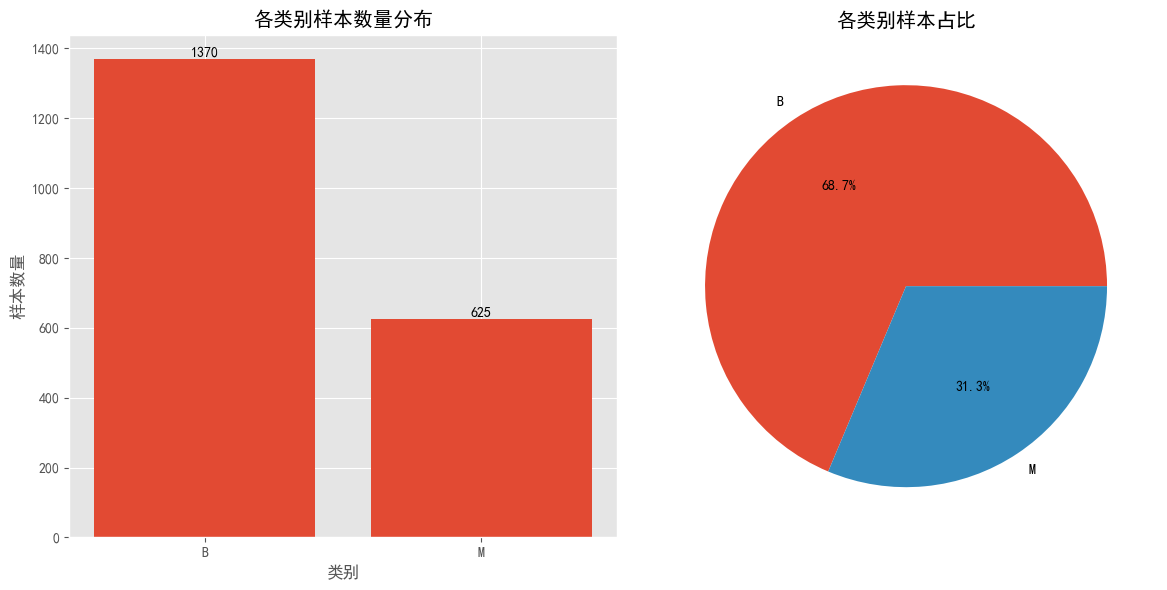


类别分布统计:
类别 B: 1370 样本 (68.7%)
类别 M: 625 样本 (31.3%)

最大类别样本数: 1370
最小类别样本数: 625
类别不平衡比率: 2.19


In [3]:
def explore_dataset(X: np.ndarray, y: np.ndarray):
    """探索数据集的基本信息"""
    # 统计各类别样本数
    class_counts = Counter(y)
    
    # 创建DataFrame用于可视化
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
    df = df.sort_values('Class')
    
    # 可视化类别分布
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(df['Class'], df['Count'])
    plt.xlabel('类别')
    plt.ylabel('样本数量')
    plt.title('各类别样本数量分布')
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.subplot(1, 2, 2)
    plt.pie(df['Count'], labels=df['Class'].tolist(), autopct='%1.1f%%')
    plt.title('各类别样本占比')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("\n类别分布统计:")
    for cls, count in sorted(class_counts.items()):
        print(f"类别 {cls}: {count} 样本 ({count/len(y)*100:.1f}%)")
    
    print(f"\n最大类别样本数: {max(class_counts.values())}")
    print(f"最小类别样本数: {min(class_counts.values())}")
    print(f"类别不平衡比率: {max(class_counts.values())/min(class_counts.values()):.2f}")
    
    return class_counts

# 探索数据集
class_counts = explore_dataset(X, y)

### 4. 可视化样本图像

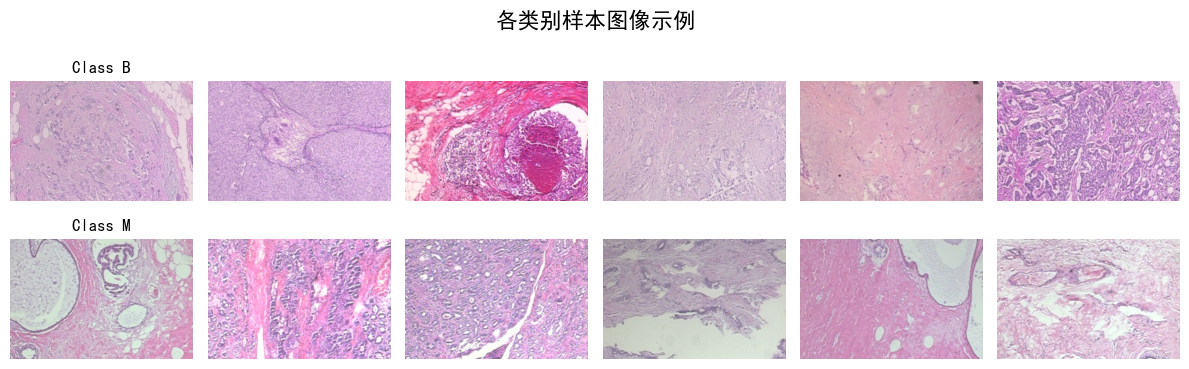

In [4]:
def visualize_samples(X: np.ndarray, y: np.ndarray, num_samples: int = 8):
    """可视化每个类别的样本图像"""
    unique_classes = sorted(np.unique(y))
    
    fig, axes = plt.subplots(len(unique_classes), num_samples, 
                            figsize=(num_samples*2, len(unique_classes)*2))
    
    if len(unique_classes) == 1:
        axes = axes.reshape(1, -1)
    
    for i, cls in enumerate(unique_classes):
        # 获取该类别的索引
        cls_indices = np.where(y == cls)[0]
        # 随机选择样本
        sample_indices = np.random.choice(cls_indices, 
                                        min(num_samples, len(cls_indices)), 
                                        replace=False)
        
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(X[idx])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'Class {cls}', fontsize=12)
    
    plt.suptitle('各类别样本图像示例', fontsize=16)
    plt.tight_layout()
    plt.show()

# 可视化样本
visualize_samples(X, y, num_samples=6)

### 5. 创建自定义数据集类

In [5]:
class BreakHisDataset(Dataset):
    """BreakHis数据集类"""

    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        transform=None,
        augment: bool = False,
    ):
        """
        参数:
            images: 图像数组
            labels: 标签数组
            transform: 图像变换（默认为 ToTensor()）
            augment: 是否进行数据增强
        """
        self.images = np.array(images)  # 确保是numpy数组
        self.labels = np.array(labels)  # 确保是numpy数组
        # 如果没有提供transform，使用默认的ToTensor
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.augment = augment

        # 标签编码
        self.label_encoder = LabelEncoder()
        self.encoded_labels = np.array(self.label_encoder.fit_transform(self.labels))
        self.num_classes = len(self.label_encoder.classes_)

        # 如果需要数据增强，创建增强变换
        if self.augment:
            self.augment_transform = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(degrees=15),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                ]
            )

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        获取单个数据样本

        返回:
            (image_tensor, label): 图像张量和标签
        """
        image = self.images[idx].copy()  # 复制以避免修改原始数据
        label = int(self.encoded_labels[idx])  # 确保是整数类型

        # 转换为PIL图像
        image_pil = Image.fromarray(image.astype("uint8"))

        # 数据增强（仅在训练时使用，在transform之前）
        if self.augment and hasattr(self, "augment_transform"):
            image_pil = self.augment_transform(image_pil)

        # 应用变换（self.transform 永远不会是 None）
        # type: ignore 用于忽略类型检查，因为我们确保 transform 返回 Tensor
        image_tensor: torch.Tensor = self.transform(image_pil)  # type: ignore

        return image_tensor, label

    def get_class_weights(self) -> torch.Tensor:
        """计算类别权重用于处理不平衡数据"""
        class_counts = np.bincount(self.encoded_labels.astype(int))
        class_weights = 1.0 / class_counts
        class_weights = class_weights / class_weights.sum()
        return torch.FloatTensor(class_weights)

### 6. 数据预处理和划分

In [6]:
def prepare_data_loaders(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 16,
    val_split: float = 0.2,
    test_split: float = 0.2,
    use_weighted_sampling: bool = True,
):
    """
    准备数据加载器

    参数:
        X: 图像数据
        y: 标签数据
        batch_size: 批次大小
        val_split: 验证集比例
        test_split: 测试集比例
        use_weighted_sampling: 是否使用加权采样处理类别不平衡
    """
    # 划分数据集
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=val_split + test_split, stratify=y, random_state=42
    )
    rel_test = test_split / (val_split + test_split)
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=rel_test, stratify=y_tmp, random_state=42
    )

    # 数据标准化
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # 创建数据集
    train_dataset = BreakHisDataset(X_train, y_train, transform=transform, augment=True)
    val_dataset = BreakHisDataset(X_val, y_val, transform=transform, augment=False)
    test_dataset = BreakHisDataset(X_test, y_test, transform=transform, augment=False)

    if use_weighted_sampling:
        # 1) 标签编码
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(y_train)  # ndarray[int]

        # 2) 统计并归一化权重
        class_counts = np.bincount(encoded_labels)  # ndarray[int]
        weights_np = 1.0 / class_counts  # ndarray[float]
        weights_np = weights_np / weights_np.sum()

        # 3) 转为 Tensor
        class_weights = torch.tensor(weights_np, dtype=torch.float)
        idx_tensor = torch.tensor(encoded_labels, dtype=torch.long)

        # 4) Tensor 索引
        sample_weights = class_weights[idx_tensor]  # 1D Tensor

        # 5) 构造加权采样器（注意这里把 Tensor 转为 Python 列表）
        sampler = WeightedRandomSampler(
            weights=sample_weights.tolist(),
            num_samples=len(train_dataset),
            replacement=True,
        )

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0
        )
    else:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
        )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )

    return train_loader, val_loader, test_loader, train_dataset.num_classes


# 准备数据加载器
train_loader, val_loader, test_loader, num_classes = prepare_data_loaders(
    X, y, batch_size=32, use_weighted_sampling=True
)

### 7. 导入CNN模型

In [7]:
# 从CNN.py导入模型
from CNN import BreakHisCNN

# 检查GPU可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建模型实例
model = BreakHisCNN(num_classes=num_classes)
model = model.to(device)

# 打印模型结构
print("\n模型结构:")
print(model)

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")

使用设备: cuda

模型结构:
BreakHisCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

总参数量: 271,426
可训练参数量: 271,426


### 8. 定义训练和验证函数

In [8]:
def train_epoch(
    model,
    train_loader,
    criterion,
    optimizer,
    device,
    accumulation_steps: int = 4,
):
    """
    训练一个 epoch，使用 tqdm 显示进度条

    参数:
        model: 待训练模型
        train_loader: 训练数据 DataLoader
        criterion: 损失函数
        optimizer: 优化器
        device: 计算设备
    返回:
        epoch_loss: 平均 loss
        epoch_acc:  准确率（%）
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    scaler = GradScaler()
    # tqdm 文本模式进度条
    with tqdm(train_loader, desc="Training", leave=False) as pbar:
        for batch_idx, (inputs, labels) in enumerate(
            tqdm(train_loader, desc="Training", leave=False)
        ):
            inputs, labels = inputs.to(device), labels.to(device)
            # 每次迭代前不立即清零梯度，改为在累计后清零
            # optimizer.zero_grad()

            # 1) 混合精度前向
            with (
                autocast()
            ):  # 自动在合适层使用 FP16 / FP32 :contentReference[oaicite:5]{index=5}
                outputs = model(inputs)
                # 将 loss 平均到每次累积
                loss = criterion(outputs, labels) / accumulation_steps

            # 2) 梯度缩放并反向
            scaler.scale(loss).backward()  # 累积梯度，但不更新参数

            # 3) 每 accumulation_steps 次迭代，才执行一次参数更新
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)  # 应用缩放后的梯度更新参数
                scaler.update()  # 更新缩放比例
                optimizer.zero_grad()  # 清理梯度，为下一轮累计做准备

            # 累计指标
            running_loss += loss.item()
            _, preds = outputs.max(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # 更新进度条后缀
            pbar.set_postfix(
                {
                    "loss": f"{running_loss/total*len(inputs):.4f}",
                    "acc": f"{100.*correct/total:.2f}%",
                }
            )

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """
    验证一个 epoch，使用 tqdm 显示进度条

    参数:
        model: 待验证模型
        val_loader: 验证数据 DataLoader
        criterion: 损失函数
        device: 计算设备
    返回:
        epoch_loss: 平均 loss
        epoch_acc:  准确率（%）
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(), tqdm(val_loader, desc="Validating", leave=False) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = outputs.max(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            pbar.set_postfix(
                {
                    "loss": f"{running_loss/total*len(inputs):.4f}",
                    "acc": f"{100.*correct/total:.2f}%",
                }
            )

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

### 9. 训练模型

In [9]:
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs: int = 50,
    learning_rate: float = 1e-3,
    device: str = "cuda",
    accumulation_steps: int = 4, 
):
    """
    整体训练函数，包含早停和学习率调度

    参数:
        model: 模型
        train_loader: 训练 DataLoader
        val_loader: 验证 DataLoader
        num_epochs: 最大训练轮数
        learning_rate: 初始学习率
        device: 计算设备
    返回:
        已加载最佳权重的 model，以及训练历史 history
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scaler = GradScaler()  # AMP 梯度缩放器 :contentReference[oaicite:2]{index=2}
    accumulation_steps = accumulation_steps
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=15
    )

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_train_acc = 0.0
    patience = 50
    patience_counter = 0
    best_model_state = None

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # 1) 训练
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        # 2) 验证
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        # 3) 调整学习率
        scheduler.step(val_loss)

        # 4) 记录历史
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # 5) 打印指标
        print(f"  ▶ train_loss={train_loss:.4f}, train_acc={train_acc:.2f}%")
        print(f"  ▶   val_loss={val_loss:.4f},   val_acc={val_acc:.2f}%")

        # 6) 早停及保存最佳
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  ✓ 保存最佳模型 (train_acc={best_train_acc:.2f}%)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n早停触发，最佳验证准确率: {best_train_acc:.2f}%")
                break

    # 加载最佳权重
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history


# 调用训练
model, history = train_model(
    model, train_loader, val_loader, num_epochs=500, learning_rate=1e-4, device="cuda"
)

C:\Users\cswzq\AppData\Local\Temp\ipykernel_32156\210309042.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP 梯度缩放器 :contentReference[oaicite:2]{index=2}
C:\Users\cswzq\AppData\Local\Temp\ipykernel_32156\306560650.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/500


Training:   0%|          | 0/38 [00:00<?, ?it/s]C:\Users\cswzq\AppData\Local\Temp\ipykernel_32156\306560650.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast()


  ▶ train_loss=0.1639, train_acc=64.75%
  ▶   val_loss=0.7340,   val_acc=33.08%
  ✓ 保存最佳模型 (train_acc=64.75%)

Epoch 2/500


  ▶ train_loss=0.1348, train_acc=76.86%
  ▶   val_loss=0.5713,   val_acc=78.95%
  ✓ 保存最佳模型 (train_acc=76.86%)

Epoch 3/500


  ▶ train_loss=0.1299, train_acc=75.52%
  ▶   val_loss=0.4123,   val_acc=84.21%

Epoch 4/500


  ▶ train_loss=0.1248, train_acc=76.36%
  ▶   val_loss=0.4199,   val_acc=79.95%

Epoch 5/500


  ▶ train_loss=0.1167, train_acc=80.20%
  ▶   val_loss=0.4251,   val_acc=85.21%
  ✓ 保存最佳模型 (train_acc=80.20%)

Epoch 6/500


  ▶ train_loss=0.1206, train_acc=78.28%
  ▶   val_loss=0.3761,   val_acc=84.21%

Epoch 7/500


  ▶ train_loss=0.1183, train_acc=78.20%
  ▶   val_loss=0.3726,   val_acc=84.71%

Epoch 8/500


  ▶ train_loss=0.1103, train_acc=81.54%
  ▶   val_loss=0.3710,   val_acc=85.96%
  ✓ 保存最佳模型 (train_acc=81.54%)

Epoch 9/500


  ▶ train_loss=0.1095, train_acc=79.95%
  ▶   val_loss=0.3891,   val_acc=86.72%

Epoch 10/500


  ▶ train_loss=0.1094, train_acc=78.86%
  ▶   val_loss=0.3802,   val_acc=85.96%

Epoch 11/500


KeyboardInterrupt: 

### 10.可视化训练历史

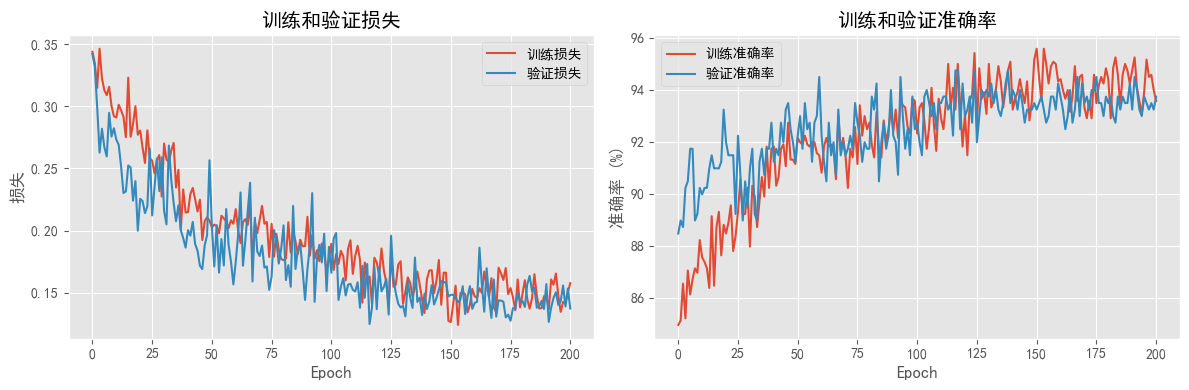

In [ ]:
def plot_training_history(history):
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 损失曲线
    ax1.plot([loss*4 for loss in history['train_loss']], label='训练损失')
    ax1.plot(history['val_loss'], label='验证损失')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('损失')
    ax1.set_title('训练和验证损失')
    ax1.legend()
    ax1.grid(True)
    
    # 准确率曲线
    ax2.plot(history['train_acc'], label='训练准确率')
    ax2.plot(history['val_acc'], label='验证准确率')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('准确率 (%)')
    ax2.set_title('训练和验证准确率')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

### 11.模型评估

测试: 100%|██████████| 25/25 [00:02<00:00, 11.21it/s]


测试集准确率: 92.48%

分类报告:
              precision    recall  f1-score   support

           B       0.97      0.92      0.94       274
           M       0.84      0.94      0.89       125

    accuracy                           0.92       399
   macro avg       0.91      0.93      0.92       399
weighted avg       0.93      0.92      0.93       399



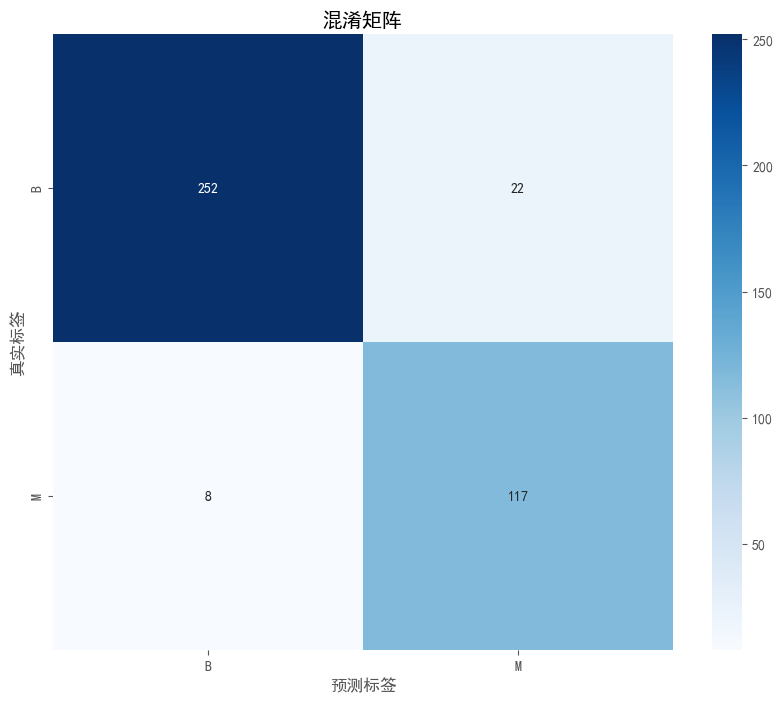

In [ ]:
def evaluate_model(model, test_loader, device):
    """评估模型性能"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='测试'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算准确率
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"\n测试集准确率: {accuracy*100:.2f}%")
    
    # 分类报告
    print("\n分类报告:")
    # 获取类别名称
    label_encoder = test_loader.dataset.label_encoder
    target_names = label_encoder.classes_
    print(classification_report(all_labels, all_predictions, 
                              target_names=target_names))
    
    # 混淆矩阵
    cm = confusion_matrix(all_labels, all_predictions)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title('混淆矩阵')
    plt.show()
    
    return accuracy, cm

# 评估模型
test_accuracy, confusion_mat = evaluate_model(model, test_loader, device)

### 12. 保存和加载模型

In [ ]:
def save_model(model, filepath, additional_info=None):
    """保存模型"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'model_architecture': model.__class__.__name__,
        'num_classes': model.fc3.out_features,
        'additional_info': additional_info
    }
    torch.save(checkpoint, filepath)
    print(f"模型已保存到: {filepath}")

def load_model(filepath, device):
    """加载模型"""
    checkpoint = torch.load(filepath, map_location=device)
    
    # 重建模型
    num_classes = checkpoint['num_classes']
    model = BreakHisCNN(num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    print(f"模型已从 {filepath} 加载")
    return model, checkpoint.get('additional_info')

# 保存模型
save_path = '.\\models\\best_breakhis_cnn_model.pth'
save_model(model, save_path, 
          additional_info={'test_accuracy': test_accuracy})

# 测试加载模型
loaded_model, info = load_model(save_path, device)
print(f"加载的模型信息: {info}")

模型已保存到: .\models\best_breakhis_cnn_model.pth
模型已从 .\models\best_breakhis_cnn_model.pth 加载
加载的模型信息: {'test_accuracy': 0.924812030075188}


C:\Users\cswzq\AppData\Local\Temp\ipykernel_1324\2334978128.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


### 13. 模型性能总结

In [ ]:
def summarize_results(history, test_accuracy, class_counts):
    """总结模型性能"""
    print("\n" + "="*60)
    print("模型训练总结")
    print("="*60)
    
    print(f"\n最佳验证准确率: {max(history['val_acc']):.2f}%")
    print(f"最终测试准确率: {test_accuracy*100:.2f}%")
    
    print(f"\n训练轮数: {len(history['train_loss'])}")
    print(f"最终训练损失: {history['train_loss'][-1]:.4f}")
    print(f"最终验证损失: {history['val_loss'][-1]:.4f}")
    
    print("\n数据集统计:")
    total_samples = sum(class_counts.values())
    print(f"总样本数: {total_samples}")
    print(f"类别数: {len(class_counts)}")
    print(f"类别不平衡比率: {max(class_counts.values())/min(class_counts.values()):.2f}")
    
    print("\n" + "="*60)

# 总结结果
summarize_results(history, test_accuracy, class_counts)


模型训练总结

最佳验证准确率: 94.74%
最终测试准确率: 92.48%

训练轮数: 201
最终训练损失: 0.0394
最终验证损失: 0.1372

数据集统计:
总样本数: 1995
类别数: 2
类别不平衡比率: 2.19

